In [1]:
# importing src directory
import sys
sys.path.append('..')
# experiment imports
import os
import math
import numpy as np
import random
from datetime import datetime as dt
from scipy.stats import truncnorm
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.optimize import minimize
# project imports
from amm.amm import AMM, SimpleFeeAMM
from amm.fee import TriangleFee, PercentFee, NoFee
# data imports
from data.kaiko import fetch_data
from api_key.my_api_key import api_key
import matplotlib.pyplot as plt


In [2]:
import os
print(os.getcwd())

C:\Users\Sean\Downloads\SHIFT\AMM-Python-drew (1)\AMM-Python-drew\src\experiment


In [3]:
# # NOTES FROM LAST MEETING:
# FOCUS MORE ON TESTING FEES THROUGH SIM

# # EXPERIMENTS TODO: # #
# [1] run for large simulations and evaluate over time - explore different time periods to test from (different market conditions and lengths of historical windows) and different frequencies (1h, 1d, 1w)
# [2] identify GBM paths that deplete pools (depletion of liquidity) and have both fall in value (impermanent loss) to show how fee accumulation compares ot general trend (law of large #s)
        # impermanent loss evaluation could allow for an expected value calculation for LP returns (expected value of fees vs. impermanent loss)
# [3] use stock data to see how compares
# [4] make sure to highlight how different fee AMMs (basically fees) are affected by different market conditions and therefore how fee accumulation is affected

# # UPDATES # #
# [1] *importing stock data to use instead of crypto (more in line with goal application and can properly use GBM to simulate)
# [2] considering train/test split for calibrating GBM and simulating trades source data (not overly urgent given not forecasting)
# [3] maybe also considering changing source data from vwap if stick with crypto data
        # multiple price streams for multiple external oracles

In [4]:
def gbm_assumption_test(log_returns):
    adf_result = adfuller(log_returns) # check for stationarity
    print("ADF Statistic:", adf_result[0]) # check for stationarity
    print("p-value:", adf_result[1])
    print("Critical Values:", adf_result[4])
    print("stationary:", adf_result[1] <= 0.05)
    # if adf_result[1] > 0.05:  # if not stationary, iteratively difference until achieved
    #     for d in range(1, max_lag + 1):
    #         diff_data = diff(log_returns, k_diff=d)
    #         adf_result = adfuller(diff_data)
    #         print(f"ADF result after differencing level {d}: {adf_result[0]}, p-value: {adf_result[1]}")
    #         if adf_result[1] <= 0.05:
    #             print("Achieved stationarity with differencing level:", d)
    #             diff_data = diff_data
    #             break
    shapiro_result = shapiro(log_returns) # check for normality
    print("Shapiro-Wilk Test Statistic:", shapiro_result[0])
    print("p-value:", shapiro_result[1])
    print("normal:", shapiro_result[1] > 0.05)
    lb_result = acorr_ljungbox(log_returns, lags=[10], return_df=True) # check for independence (autocorrelation)
    print("Ljung-Box test:")
    print(lb_result)
    print("independent:", lb_result['lb_pvalue'].iloc[0] > 0.05)
    if lb_result['lb_pvalue'].iloc[0] < 0.05: # if autocorrelation detected, adjust
        print("Autocorrelation detected:") 
        plot_pacf(log_returns, lags=40) # plot partial autocorrelation function
        plt.title('Partial Autocorrelation Function (PACF)')
        plt.show()

In [5]:

# Define the log-likelihood function
def neg_log_likelihood(params, log_returns):
    """
    calculate negative log likelihood of a normal distribution for calibrating GBM
    params: tuple, mu and sigma
    """
    #gbm_assumption_test(log_returns) # test gbm assumptions
    mu, sigma = params # define mu and sigma
    estimated_mu = np.mean(log_returns) # estimate mu
    estimated_var = np.sum((log_returns - estimated_mu)**2) / len(log_returns) # estimate variance
    return 0.5 * len(log_returns) * np.log(2 * np.pi * estimated_var) + 0.5 / estimated_var * np.sum((log_returns - mu)**2) # return negative log likelihood

In [6]:
def calibrate_gbm(data, frequency, T, N, type, max_lag=10, alpha=0.05):
    """
    calibrate geometric brownian motion
    
    calibrate gbm model by pulling data from kaiko api

    data (pd.DataFrame): price data
    freq (str): frequency of data (1h, 1d, 1w)
    T (float): terminal time
    N (int): number of time steps
    type (str): type of calibration (reg, mle)
    max_lag (int): maximum lag for autocorrelation test (default=10)
    alpha (float): significance level for hypothesis tests (default=0.05)

    return numpy.ndarray: simulated gbm path
    """
    if type == "reg":
        returns = np.log(data / data.shift(1)) # get returns
        gbm_assumption_test(returns) # test gbm assumptions
        mu = returns.mean() * 252  # annualized return
        sigma = returns.std() * 252 ** 0.5 # annualized volatility
        print(f'Estimated {frequency} Mu:', mu, 'Estimated Annualized Mu:', mu * 365.25)
        print(f'Estimated {frequency} Sigma:', sigma, 'Estimated Annualized Sigma:', sigma * 365.25**0.5)
        S0 = data.iloc[-1]["price"] # get LAST price in series
        dt = T / N # time step size
        t = np.linspace(0, T, N)
        W = np.random.standard_normal(size=N)
        W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
        X = (mu - 0.5 * sigma**2) * t + sigma * W 
        S = S0 * np.exp(X)  # Geometric Brownian motion
        
        #plt.plot(S)
        
        return S
    elif type == "mle":
        log_returns = np.log(1 + data['price'].pct_change().dropna()) # calculate log returns
        result = minimize(neg_log_likelihood, [0.05, 0.2], args=(log_returns,), bounds=((None, None), (1e-4, None)))
 # minimize the negative log-likelihood
        mu = result.x[0] * 365.25 # annualize mu
        sigma = result.x[1] * 365.25**0.5 # annualize sigma
        print(f'Estimated {frequency} Mu:', result.x[0], 'Estimated Annualized Mu:', mu) # using 365.25 instead of 252 bcs operate 24/7
        print(f'Estimated {frequency} Sigma:', result.x[1], 'Estimated Annualized Sigma:', sigma)
        S0 = data.iloc[-1]["price"] # get LAST price in series
        dt = T / N # time step size
        t = np.linspace(0, T, N)
        W = np.random.standard_normal(size=N)
        W = np.cumsum(W) * np.sqrt(dt)  # standard BM
        X = (mu - 0.5 * sigma**2) * t + sigma * W 
        S = S0 * np.exp(X)  # GBM
        
        
        #print(S)
        #plt.plot(S)
        
        return S

In [7]:
def get_gbm_data(asset, start_date, end_date, freq, api_key):
    """
    get gbm data from kaiko api or local storage

    asset (str): asset symbol
    start_date (str): start date of data
    end_date (str): end date of data
    freq (str): frequency of data (1h, 1d, 1w)
    api_key (str): kaiko api key

    return pd.DataFrame: price data
    """
    # check if data exists, if not fetch data
    if os.path.exists(f"/crypto_data/{asset}-usd_{start_date}_{end_date}_{freq}.csv"):
        data =  pd.read_csv(f"/crypto_data/{asset}-usd_{start_date}_{end_date}_{freq}.csv")["price"]
    else: data = fetch_data(api_key, asset+"-usd", start_date, end_date, freq)
    return data

In [8]:
def geometric_brownian_motion(mu, sigma, S0, T, N, dt):
    """
    Generate geometric brownian motion.

    Parameters:
        mu (float): Drift coefficient.
        sigma (float): Diffusion coefficient.
        S0 (float): Initial value.
        T (float): Terminal time.
        N (int): Number of time steps.
        dt (float): Time step size.

    Returns:
        numpy.ndarray: Simulated GBM path.
    """
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size=N)
    W = np.cumsum(W) * np.sqrt(dt)  # Standard Brownian motion
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    S = S0 * np.exp(X)  # Geometric Brownian motion
    return S

In [345]:
def sim1(n, pair, start_dt, end_dt, frequency):
    """
    simulate AMM market with data calibrated GBM for external oracles and trading agents
    n (int): number of simulations
    pair (str): asset pair for data (e.g. btc-eth)
    asset1_n (int): number of asset1 tokens
    asset2_n (int): number of asset2 tokens
    start_dt (str): start date for data (YYYY-MM-DD)
    end_dt (str): end date for data (YYYY-MM-DD)
    frequency (str): frequency of data (1h, 1d, 1w)
    return list: list of dataframes for each simulation 
    """

    # # SIM STORAGE # #
    # create list to store dfs from each simulation of amms
    sim_amm_dfs= []
    sim_amms = []
    # parse asset1 and asset2, create USD denominated pairs
    asset1 = pair.split("-")[0] 
    asset2 = pair.split("-")[1]

    # # DATA & GBM CALIBRATION # #
    """
    data = get_gbm_data(asset1, start_dt, end_dt, frequency, api_key) # get data for asset1
    difference = dt.strptime(end_dt, '%Y-%m-%dT%H:%M:%SZ') - dt.strptime(start_dt, '%Y-%m-%dT%H:%M:%SZ')
    T_years = difference.days / 365.25  # using 365.25 to account for leap years
    n_timesteps = len(data) # number of timesteps in data
    asset1_data = get_gbm_data(asset1, start_dt, end_dt, frequency, api_key) # get data for asset1
    asset2_data = get_gbm_data(asset2, start_dt, end_dt, frequency, api_key) # get data for asset2
    asset1_data['timestamp'] = pd.to_datetime(asset1_data['timestamp']) # convert timestamp to datetime
    asset2_data['timestamp'] = pd.to_datetime(asset2_data['timestamp'])
    asset1_data['price'] = pd.to_numeric(asset1_data['price']) # convert price to numeric
    asset2_data['price'] = pd.to_numeric(asset2_data['price'])
    
    marketDF = pd.merge(asset1_data, asset2_data, on='timestamp', how='inner', suffixes=("_" + asset1, "_" + asset2)) # merge dataframes on timestamp saving price for each asset denominated in USD for storing AMM market data
    # calculate market ratio of asset1/asset2
    """
    
    marketDF = pd.DataFrame({f'price_{asset1}': geometric_brownian_motion(0.1, 0.15, 16550.764470, 1.0, 1000, 1.0/1000),
                             f'price_{asset2}': geometric_brownian_motion(0.1, 0.15, 1196.325933, 1.0, 1000, 1.0/1000)})
    
    marketDF[f'mrkt_{asset1}/{asset2}'] = marketDF[f'price_{asset1}'] / marketDF[f'price_{asset2}'] 
    
    
    # add columns for trade tracking (amm ratio, inventory, averages)
    new_cols = [f'amm_{asset1}/{asset2}', f'{asset1}_inv', f'{asset2}_inv', 'L_inv']
    marketDF = marketDF.assign(**{col: None for col in new_cols})

    marketDF.loc[marketDF.index[0], f'amm_{asset1}/{asset2}'] = marketDF.loc[marketDF.index[0], f'mrkt_{asset1}/{asset2}']

    n_timesteps = 1000  
    
    mean = 10  # Mean
    sigma = 5# Standard deviation
    a = (0 - mean) / sigma  # Lower bound
    b = (100 - mean) / sigma  # Upper bound

    # Create a frozen distribution object
    trade_sizes = truncnorm(a, b, loc=mean, scale=sigma)
    
    values_list = (trade_sizes.rvs(size=1000)).tolist()

    fig, ax1 = plt.subplots()

        # Set the background color of the figure to white
    fig.set_facecolor('white')
    
    # Set the background color of the axes to white
    ax1.set_facecolor('white')
    # Assuming 'markets[0]' is a DataFrame with the correct index
    # Plotting the first series on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Asset A', color=color)
    ax1.plot(marketDF.index, marketDF[f'price_{asset1}'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Creating a secondary y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:grey'
    ax2.set_ylabel('Asset B', color=color)
    ax2.plot(marketDF.index, marketDF[f'price_{asset2}'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Title and grid
    plt.title('GBM Paths for Assets A and B')
    plt.grid(True)
    
    # Show the plot
    plt.show()

    # # MARKET MOVING AVERAGES # #
    # add columns for moving averages
    """
    marketDF[f'20mavg_{asset1}'] = marketDF[f'price_{asset1}'].rolling(window=20).mean()
    marketDF[f'50mavg_{asset1}'] = marketDF[f'price_{asset1}'].rolling(window=50).mean()
    marketDF[f'200mavg_{asset1}'] = marketDF[f'price_{asset1}'].rolling(window=200).mean()
    marketDF[f'20mavg_{asset2}'] = marketDF[f'price_{asset2}'].rolling(window=20).mean()
    marketDF[f'50mavg_{asset2}'] = marketDF[f'price_{asset2}'].rolling(window=50).mean()
    marketDF[f'200mavg_{asset2}'] = marketDF[f'price_{asset2}'].rolling(window=200).mean()
    """
    
    # # TIME SERIES SIMULATIONS # #
    for simulation in range(n): # for each simulation create new set of amms & run new set of trades
        """
        plt.plot(marketDF[f'price_{asset1}'] / marketDF[f'price_{asset1}'][0], label = "Asset 1")
        plt.plot(marketDF[f'price_{asset2}'] / marketDF[f'price_{asset2}'][0], label = "Asset 2")
        plt.legend()
        plt.show()
        """
        
        
        market = marketDF.copy() # create new market df for each simulation
        nofeeAMM = SimpleFeeAMM(fee_structure = NoFee())  # setup amms to simulate
        percentAMM = SimpleFeeAMM(fee_structure = PercentFee(0.003))
        triAMM = SimpleFeeAMM(fee_structure = TriangleFee(0.03, 0.0001, -1)) 
        amm_cols = [f'{asset1}_inv', f'{asset2}_inv', 'L_inv', f'{asset1}', f'{asset2}', 'L', f'F{asset1}', f'F{asset2}', 'FL'] # setup new set of dfs to save simulations
        percentDF = pd.DataFrame(columns=amm_cols)
        nofeeDF = pd.DataFrame(columns=amm_cols)
        triDF = pd.DataFrame(columns=amm_cols)
        amms = [(nofeeAMM, nofeeDF), (percentAMM, percentDF), (triAMM, triDF)] # store pairs of amm type & df for updating
        #asset1_gbm = calibrate_gbm(data, frequency, T_years, n_timesteps, "mle") # calibrate gbm for asset1 w/ MLE
        #asset2_gbm = calibrate_gbm(data, frequency, T_years, n_timesteps, "mle") # calibrate gbm for asset2 w/ MLE
        #asset1_data['gbm_price'] = asset1_gbm # add gbm price to df
        #asset2_data['gbm_price'] = asset2_gbm # add gbm price to df
        
        # # SIMULATION # #
        markets = []
        for amm, df in amms:
            amm_market = market.copy()
            df = pd.DataFrame()
            num_trades = 0
            i = 0
            for t in range(n_timesteps): # iterate over each timestep in crypto market data
                if amm == percentAMM:
                    if amm_market[f'amm_{asset1}/{asset2}'][t] > (amm_market[f'mrkt_{asset1}/{asset2}'][t] * 1.003): # rule-based arbitrage agents in the market
                        asset_out, asset_in, asset_in_n = "B", "A", values_list[i] # modeling market efficiency
                        num_trades += 1
                    elif (amm_market[f'amm_{asset1}/{asset2}'][t] * 1.003) < amm_market[f'mrkt_{asset1}/{asset2}'][t]:
                        asset_out, asset_in, asset_in_n = "A", "B", values_list[i] * amm_market[f'mrkt_{asset1}/{asset2}'][t]
                        num_trades += 1
                    else:
                        asset_out, asset_in, asset_in_n = "A", "B", 0.0
                elif amm == triAMM:
                    trade_size = values_list[i]
                    if amm_market[f'amm_{asset1}/{asset2}'][t] > (amm_market[f'mrkt_{asset1}/{asset2}'][t]):
                        asset_out, asset_in, asset_in_n = "B", "A", trade_size
                    elif (amm_market[f'amm_{asset1}/{asset2}'][t]) < amm_market[f'mrkt_{asset1}/{asset2}'][t]:
                        asset_out, asset_in, asset_in_n = "A", "B", values_list[i] * amm_market[f'mrkt_{asset1}/{asset2}'][t]
                    else:
                        asset_out, asset_in, asset_in_n = "A", "B", 0.0
                    ass_out, info = amm._quote_no_fee(asset_out, asset_in, trade_size)
                    curr_ratio = new_row[f'{asset1}_inv'] / new_row[f'{asset2}_inv']
                    new_ratio = (new_row[f'{asset1}_inv'] + info["asset_delta"]["A"]) / (new_row[f'{asset2}_inv'] + info["asset_delta"]["B"])
                    difference = 1 - (new_ratio / curr_ratio)
                    if abs(difference) > .003: baseline = 1.00155
                    else: baseline = 1.003
                    if amm_market[f'amm_{asset1}/{asset2}'][t] > (amm_market[f'mrkt_{asset1}/{asset2}'][t] * baseline): # rule-based arbitrage agents in the market
                        asset_out, asset_in, asset_in_n = "B", "A", trade_size # modeling market efficiency
                        num_trades += 1
                    elif (amm_market[f'amm_{asset1}/{asset2}'][t] * baseline) < amm_market[f'mrkt_{asset1}/{asset2}'][t]:
                        asset_out, asset_in, asset_in_n = "A", "B", values_list[i] * amm_market[f'mrkt_{asset1}/{asset2}'][t]
                        num_trades += 1
                    else:
                        asset_out, asset_in, asset_in_n = "A", "B", 0.0
                    #asset_out, asset_in, asset_in_n = "A", "B", 0.0
                    #print("Triangle", t)
                else:
                    if amm_market[f'amm_{asset1}/{asset2}'][t] > (amm_market[f'mrkt_{asset1}/{asset2}'][t]):
                        asset_out, asset_in, asset_in_n = "B", "A", values_list[i]
                        num_trades += 1
                    elif (amm_market[f'amm_{asset1}/{asset2}'][t]) < amm_market[f'mrkt_{asset1}/{asset2}'][t]:
                        asset_out, asset_in, asset_in_n = "A", "B", values_list[i] * amm_market[f'mrkt_{asset1}/{asset2}'][t]
                        num_trades += 1
                    else:
                        asset_out, asset_in, asset_in_n = "A", "B", 0.0
                succ, info = amm.trade_swap(asset_out, asset_in, asset_in_n)
                new_row = {f'{asset1}_inv': amm.portfolio["A"], f'{asset2}_inv': amm.portfolio["B"], 'LInv': amm.portfolio['L'],
                        asset1: info['asset_delta']["A"], asset2: info['asset_delta']["B"], 'L': amm.portfolio["L"], f'F{asset1}': amm.fees["A"], f'F{asset2}': amm.fees["B"], 'FL': amm.fees['L']}
                if df.empty:
                    df = pd.DataFrame([new_row])
                else:
                    df = df.append(new_row, ignore_index=True)
                    if t+1 >= n_timesteps:
                        #print(num_trades)
                        #print(amm_market)
                        break
                i += 1
                amm_market.loc[marketDF.index[t+1], f'amm_{asset1}/{asset2}'] = new_row[f'{asset2}_inv'] / new_row[f'{asset1}_inv']
            markets.append(amm_market)
            sim_amms.append(df)
            sim_amms.append(amm)
    return sim_amm_dfs, sim_amms, markets, marketDF[f'price_{asset1}'], marketDF[f'price_{asset2}']# return list of dfs for each simulation

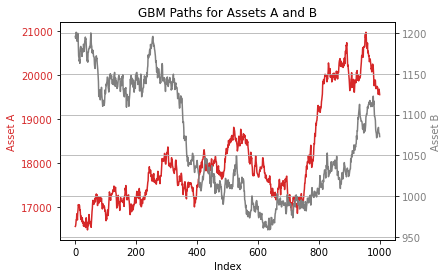

In [346]:
simm_amm_dfs, simm_amms, markets, asset1_gbm, asset2_gbm = sim1(1, "btc-eth", '2023-01-01T00:00:00Z', '2024-01-01T00:00:00Z', "1d")

In [347]:
simm_amms

[          btc_inv        eth_inv          LInv        btc         eth  \
 0    10000.000000  138346.616200  37194.974956   0.000000    0.000000   
 1     9990.593822  138476.870014  37194.974956  -9.406178  130.253814   
 2     9982.809189  138584.854804  37194.974956  -7.784633  107.984791   
 3     9982.137268  138594.183274  37194.974956  -0.671921    9.328470   
 4     9975.308389  138689.061842  37194.974956  -6.828879   94.878567   
 ..            ...            ...           ...        ...         ...   
 995   8725.144588  158560.829333  37194.974956   9.554320 -173.819654   
 996   8713.125152  158779.558172  37194.974956 -12.019436  218.728839   
 997   8691.225085  159179.649421  37194.974956 -21.900068  400.091249   
 998   8701.995008  158982.642578  37194.974956  10.769923 -197.006843   
 999   8714.590793  158752.854256  37194.974956  12.595785 -229.788322   
 
                 L  Fbtc  Feth   FL  
 0    37194.974956   0.0   0.0  0.0  
 1    37194.974956   0.0   0.0  0.

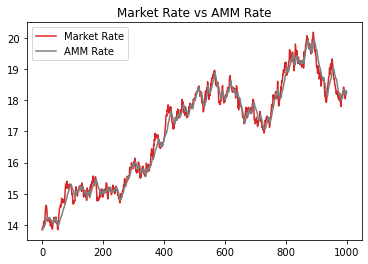

In [348]:
# Start with setting a white background for the figure
plt.figure(facecolor='white')

# Plotting the first series
plt.plot(markets[0]['mrkt_btc/eth'], color="tab:red", label="Market Rate")

# Plotting the second series
plt.plot(markets[0]['amm_btc/eth'], color="tab:grey", label="AMM Rate")

# Adding title and legend
plt.title("Market Rate vs AMM Rate")
plt.legend()

# Set the axes background color to white (if needed, usually default)
ax = plt.gca()  # Get current axes
ax.set_facecolor('white')

# Show the plot with a white background
plt.show()

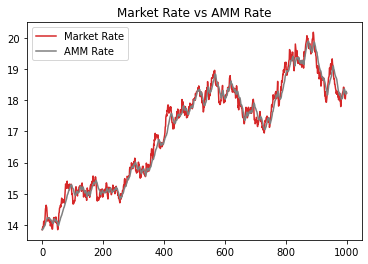

In [349]:
# Start with setting a white background for the figure
plt.figure(facecolor='white')

# Plotting the first series
plt.plot(markets[1]['mrkt_btc/eth'], color="tab:red", label="Market Rate")

# Plotting the second series
plt.plot(markets[1]['amm_btc/eth'], color="tab:grey", label="AMM Rate")

# Adding title and legend
plt.title("Market Rate vs AMM Rate")
plt.legend()

# Set the axes background color to white (if needed, usually default)
ax = plt.gca()  # Get current axes
ax.set_facecolor('white')

# Show the plot with a white background
plt.show()

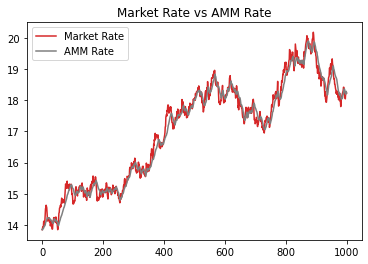

In [350]:
# Start with setting a white background for the figure
plt.figure(facecolor='white')

# Plotting the first series
plt.plot(markets[2]['mrkt_btc/eth'], color="tab:red", label="Market Rate")

# Plotting the second series
plt.plot(markets[2]['amm_btc/eth'], color="tab:grey", label="AMM Rate")

# Adding title and legend
plt.title("Market Rate vs AMM Rate")
plt.legend()

# Set the axes background color to white (if needed, usually default)
ax = plt.gca()  # Get current axes
ax.set_facecolor('white')

# Show the plot with a white background
plt.show()

In [351]:
fees_percent = (simm_amms[0], simm_amms[1])

In [352]:
LfA = []
LfB = []
val_in_L = []
port_in_L = []
for i, row in fees_percent[0].iterrows():
    LfA.append(row["btc_inv"] / row["LInv"])
    LfB.append(row["eth_inv"] / row["LInv"] )
    val_in_L.append((1/LfA[i] * row["Fbtc"]) + (1/LfB[i] * row["Feth"]))
    total = ((1/LfA[i] * row["btc_inv"]) + (1/LfB[i] * row["eth_inv"]) + val_in_L[i])
    
    port_in_L.append(total * max(LfA[i] * asset1_gbm[i], LfB[i] * asset2_gbm[i]))

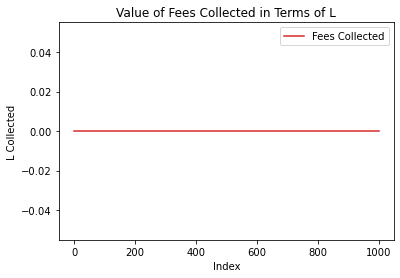

0.0


In [353]:
# Creating the plot with a specific color and label
plt.plot(val_in_L, label="Fees Collected", color="tab:red")

# Setting labels and titles directly via plt interface
plt.xlabel('Index')  # Correct method to set x-axis label
plt.ylabel('L Collected')      # Correct method to set y-axis label

# Adding a legend
plt.legend()

# Setting the background color of the plot area
plt.gca().set_facecolor('white')  # 'gca' stands for 'get current axis'

# Set the overall background color of the figure
plt.gcf().set_facecolor('white')  # 'gcf' stands for 'get current figure'

plt.title("Value of Fees Collected in Terms of L")

# Display the plot
plt.show()

print(val_in_L[-1])


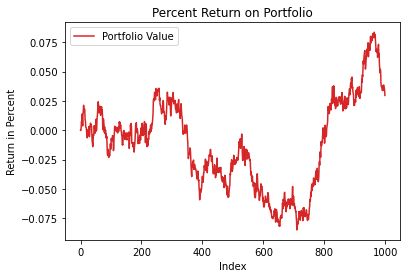

In [354]:
# Creating the plot with a specific color and label
plt.plot((port_in_L / port_in_L[0]) - 1, label="Portfolio Value", color="tab:red")

# Setting labels and titles directly via plt interface
plt.xlabel('Index')  # Correct method to set x-axis label
plt.ylabel('Return in Percent')      # Correct method to set y-axis label

# Adding a legend
plt.legend()

# Setting the background color of the plot area
plt.gca().set_facecolor('white')  # 'gca' stands for 'get current axis'

# Set the overall background color of the figure
plt.gcf().set_facecolor('white')  # 'gcf' stands for 'get current figure'

plt.title("Percent Return on Portfolio")

# Display the plot
plt.show()


In [355]:
print(port_in_L[999] / port_in_L[0])

1.0296732110458573


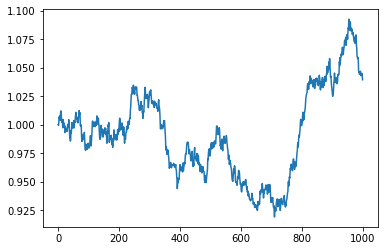

In [356]:
pct_1 = asset1_gbm / asset1_gbm[0]
pct_2 = asset2_gbm / asset2_gbm[0]
port = pct_1 * 0.5 + pct_2 * 0.5

plt.plot(port)

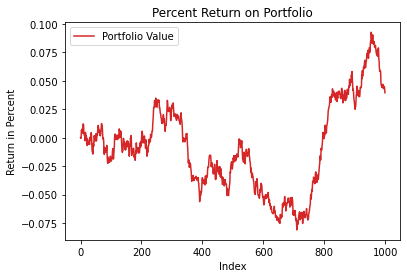

In [357]:
# Creating the plot with a specific color and label
plt.plot(port - 1, label="Portfolio Value", color="tab:red")

# Setting labels and titles directly via plt interface
plt.xlabel('Index')  # Correct method to set x-axis label
plt.ylabel('Return in Percent')      # Correct method to set y-axis label

# Adding a legend
plt.legend()

# Setting the background color of the plot area
plt.gca().set_facecolor('white')  # 'gca' stands for 'get current axis'

# Set the overall background color of the figure
plt.gcf().set_facecolor('white')  # 'gcf' stands for 'get current figure'

plt.title("Percent Return on Portfolio")

# Display the plot
plt.show()

In [358]:
port[999]

1.0394424269088287


 0


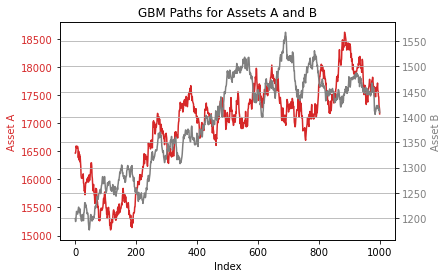


 1


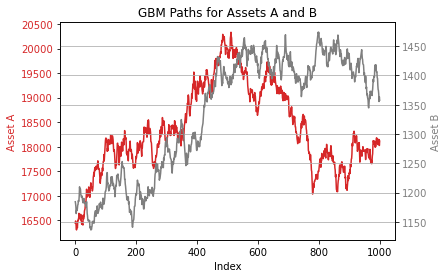


 2


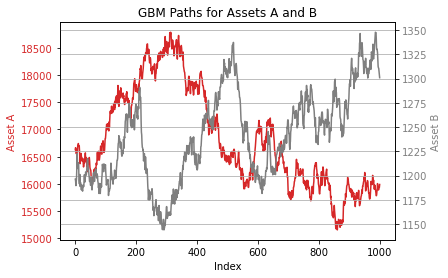


 3


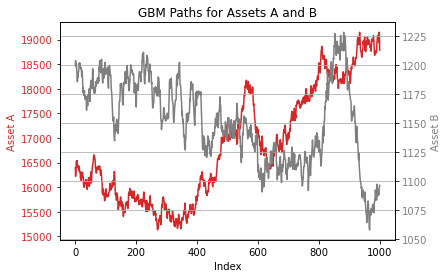


 4


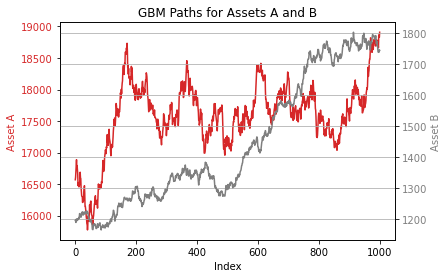


 5


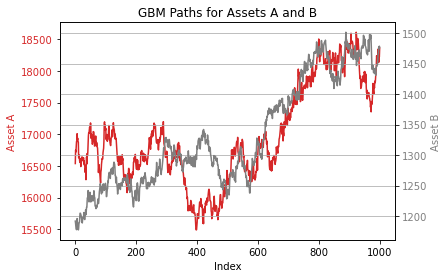


 6


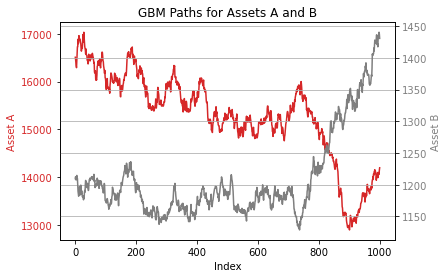


 7


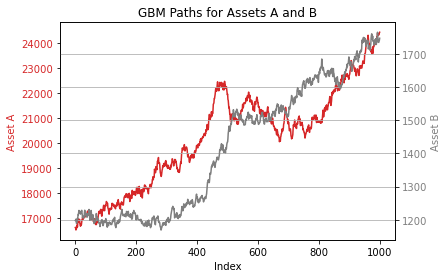


 8


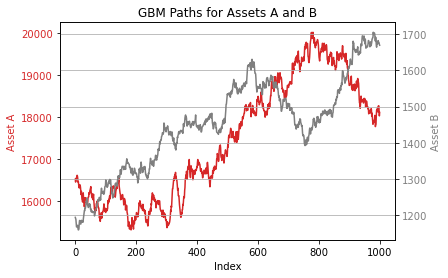


 9


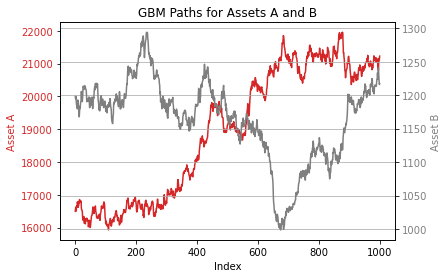


 10


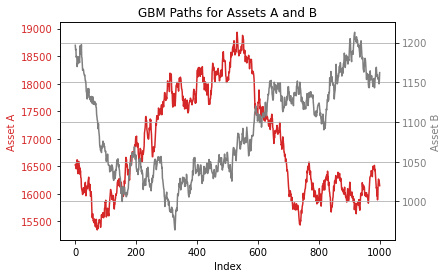


 11


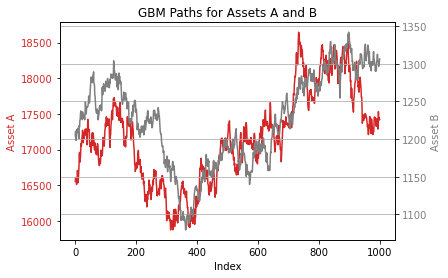


 12


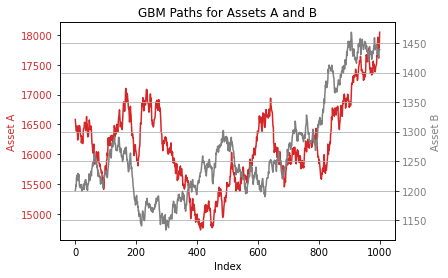


 13


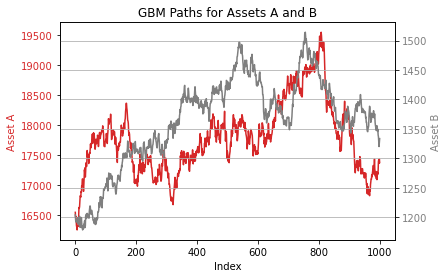


 14


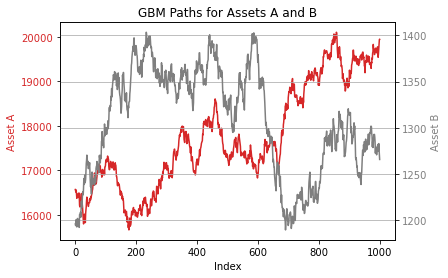


 15


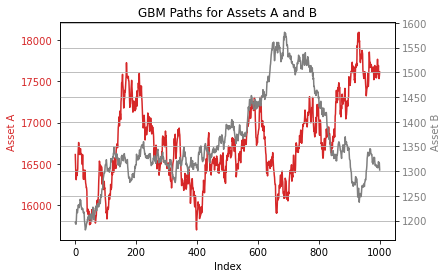


 16


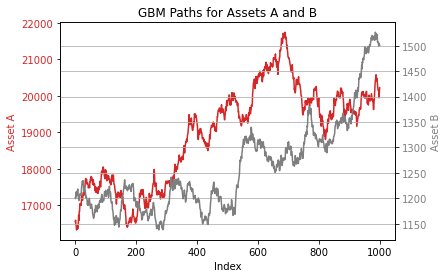


 17


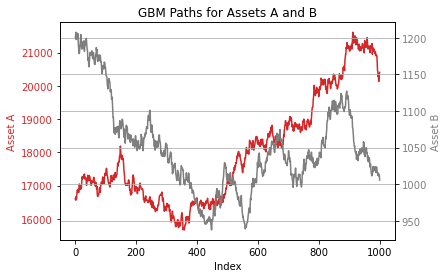


 18


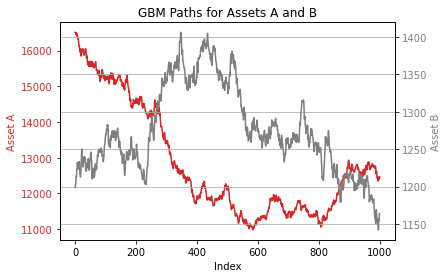


 19


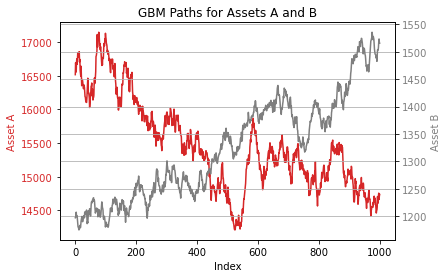


 20


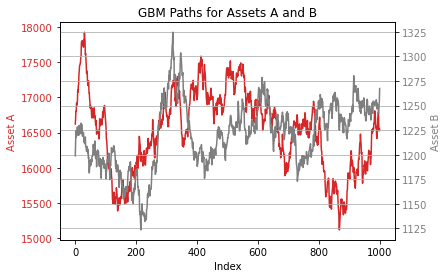


 21


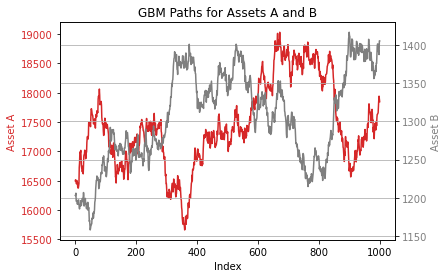


 22


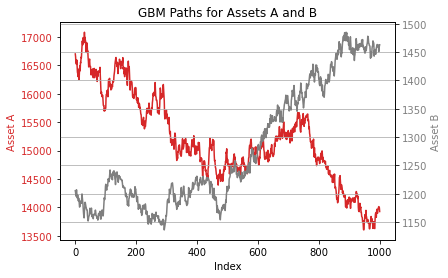


 23


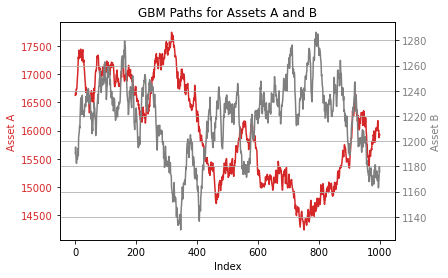


 24


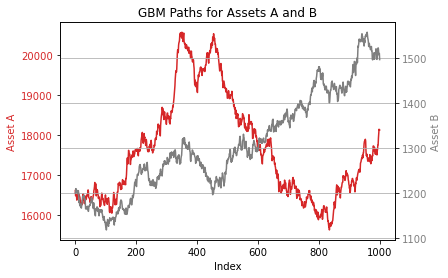


 25


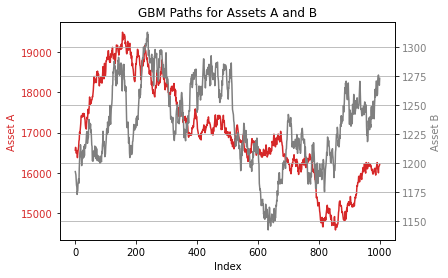


 26


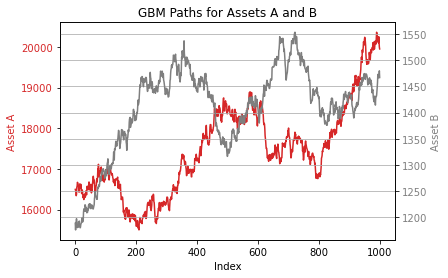


 27


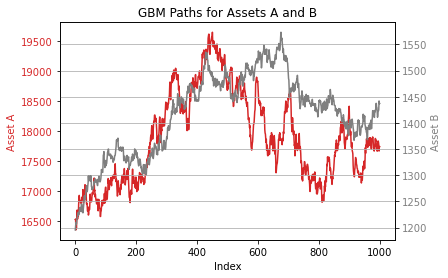


 28


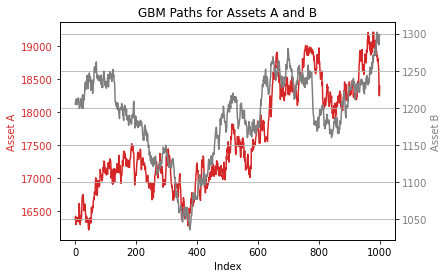


 29


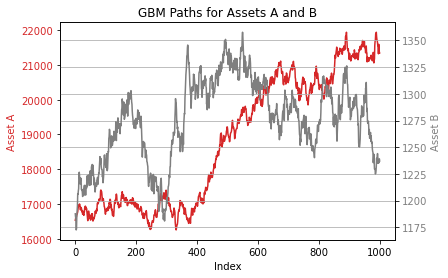

In [359]:
tri_amm = {"fees_collected": [], 
           "portfolio_returns": []}

pct_amm = {"fees_collected": [], 
           "portfolio_returns": []}

none_f_amm = []

no_amm = []

for i in range(30):
    print("\n",i)
    simm_amm_dfs, simm_amms, markets, asset1_gbm, asset2_gbm = sim1(1, "btc-eth", '2023-01-01T00:00:00Z', '2024-01-01T00:00:00Z', "1d")
    fees_percent = (simm_amms[0], simm_amms[2], simm_amms[4])
    for j, item in enumerate(fees_percent):
        #print(j, item)
        rows = [0, 999]
        for num in rows:
            row = item.iloc[num]
            LfA = (row["LInv"] / row["btc_inv"])
            LfB = (row["LInv"] / row["eth_inv"])
            val_in_L = ((1/LfA * row["Fbtc"]) + (1/LfB * row["Feth"]))
            total = ((1/LfA * row["btc_inv"]) + (1/LfB * row["eth_inv"]) + val_in_L)
            if num == 0:
                start_in_L = total
            else: port_in_L = total / start_in_L
        if j == 0:
            none_f_amm.append(port_in_L)
        elif j == 1:
            pct_amm["portfolio_returns"].append(port_in_L)
            pct_amm["fees_collected"].append(val_in_L)
        else:
            tri_amm["portfolio_returns"].append(port_in_L)
            tri_amm["fees_collected"].append(val_in_L)
    
    pct_1 = asset1_gbm / asset1_gbm[0]
    pct_2 = asset2_gbm / asset2_gbm[0]
    port = pct_1 * 0.5 + pct_2 * 0.5
    no_amm.append(port[999])

In [361]:
print(np.mean(tri_amm["portfolio_returns"]))
print(np.mean(pct_amm["portfolio_returns"]))
print(np.mean(none_f_amm))
print(np.mean(no_amm))

0.957990662209666
0.9580450338694317
0.9569049715208238
1.109744010124782


<class 'list'>


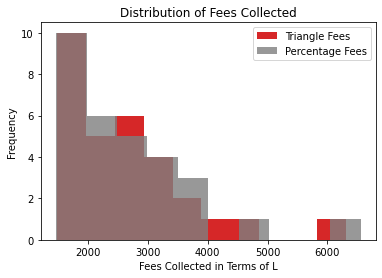

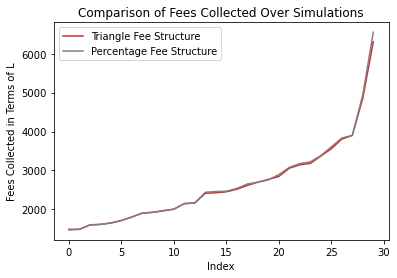

In [344]:
print(type(tri_amm["fees_collected"]))

tri = sorted(tri_amm["fees_collected"])
pct = sorted(pct_amm["fees_collected"])

plt.hist(tri, 10, color = "tab:red", label = "Triangle Fees")
plt.hist(pct, 10, color = "tab:grey", label = "Percentage Fees", alpha = 0.8)
plt.xlabel("Fees Collected in Terms of L")
plt.ylabel("Frequency")
plt.legend()
plt.gca().set_facecolor('white')  # 'gca' stands for 'get current axis'

# Set the overall background color of the figure
plt.gcf().set_facecolor('white')  # 'gcf' stands for 'get current figure'

plt.title("Distribution of Fees Collected")

plt.show()

plt.plot(tri, label = "Triangle Fee Structure", color = "tab:red")
plt.plot(pct, label = "Percentage Fee Structure", color = "tab:grey")

# Setting labels and titles directly via plt interface
plt.xlabel('Index')  # Correct method to set x-axis label
plt.ylabel('Fees Collected in Terms of L')      # Correct method to set y-axis label

# Adding a legend
plt.legend()

# Setting the background color of the plot area
plt.gca().set_facecolor('white')  # 'gca' stands for 'get current axis'

# Set the overall background color of the figure
plt.gcf().set_facecolor('white')  # 'gcf' stands for 'get current figure'

plt.title("Comparison of Fees Collected Over Simulations")

# Display the plot

plt.show()

In [ ]:

tri_amm = {"fees_collected": [], 
           "portfolio_returns": []}

pct_amm = {"fees_collected": [], 
           "portfolio_returns": []}

none_f_amm = []

no_amm = []

for i in range(100):
    print("\n",i)
    simm_amm_dfs, simm_amms, markets, asset1_gbm, asset2_gbm = sim1(1, "btc-eth", '2023-01-01T00:00:00Z', '2024-01-01T00:00:00Z', "1d")
    fees_percent = (simm_amms[0], simm_amms[2], simm_amms[4])
    for j, item in enumerate(fees_percent):
        #print(j, item)
        rows = [0, 499]
        for num in rows:
            row = item.iloc[num]
            LfA = (row["LInv"] / row["btc_inv"])
            LfB = (row["LInv"] / row["eth_inv"])
            val_in_L = ((1/LfA * row["Fbtc"]) + (1/LfB * row["Feth"]))
            total = ((1/LfA * row["btc_inv"]) + (1/LfB * row["eth_inv"]) + val_in_L)
            if num == 0:
                start_in_L = (min((total * LfA) * asset1_gbm[num], (total * LfB) * asset2_gbm[num]))
            else: port_in_L = (min((total * LfA) * asset1_gbm[num], (total * LfB) * asset2_gbm[num])) / start_in_L
        if j == 0:
            none_f_amm.append(port_in_L)
        elif j == 1:
            pct_amm["portfolio_returns"].append(port_in_L)
            pct_amm["fees_collected"].append(val_in_L)
        else:
            tri_amm["portfolio_returns"].append(port_in_L)
            tri_amm["fees_collected"].append(val_in_L)
    
    pct_1 = asset1_gbm / asset1_gbm[0]
    pct_2 = asset2_gbm / asset2_gbm[0]
    port = pct_1 * 0.5 + pct_2 * 0.5
    no_amm.append(port[499])

In [ ]:
print(np.mean(tri_amm["portfolio_returns"]))
print(np.mean(pct_amm["portfolio_returns"]))
print(np.mean(none_f_amm))
print(np.mean(no_amm))

In [ ]:
print(np.mean(tri_amm["fees_collected"]))
print(np.mean(pct_amm["fees_collected"]))

In [ ]:
tri_amm = {"fees_collected": [], 
           "portfolio_returns": []}

pct_amm = {"fees_collected": [], 
           "portfolio_returns": []}

none_f_amm = []

no_amm = []

for i in range(100):
    print("\n",i)
    simm_amm_dfs, simm_amms, markets, asset1_gbm, asset2_gbm = sim1(1, "btc-eth", '2023-01-01T00:00:00Z', '2024-01-01T00:00:00Z', "1d")
    fees_percent = (simm_amms[0], simm_amms[2], simm_amms[4])
    for j, item in enumerate(fees_percent):
        #print(j, item)
        rows = [0, 499]
        for num in rows:
            row = item.iloc[num]
            LfA = (row["LInv"] / row["btc_inv"])
            LfB = (row["LInv"] / row["eth_inv"])
            val_in_L = ((1/LfA * row["Fbtc"]) + (1/LfB * row["Feth"]))
            total = ((1/LfA * row["btc_inv"]) + (1/LfB * row["eth_inv"]) + val_in_L)
            if num == 0:
                start_in_L = (min((total * LfA) * asset1_gbm[num], (total * LfB) * asset2_gbm[num]))
            else: port_in_L = (min((total * LfA) * asset1_gbm[num], (total * LfB) * asset2_gbm[num])) / start_in_L
        if j == 0:
            none_f_amm.append(port_in_L)
        elif j == 1:
            pct_amm["portfolio_returns"].append(port_in_L)
            pct_amm["fees_collected"].append(val_in_L)
        else:
            tri_amm["portfolio_returns"].append(port_in_L)
            tri_amm["fees_collected"].append(val_in_L)
    
    pct_1 = asset1_gbm / asset1_gbm[0]
    pct_2 = asset2_gbm / asset2_gbm[0]
    port = pct_1 * 0.5 + pct_2 * 0.5
    no_amm.append(port[499])

In [ ]:
print(np.mean(tri_amm["portfolio_returns"]))
print(np.mean(pct_amm["portfolio_returns"]))
print(np.mean(none_f_amm))
print(np.mean(no_amm))

In [ ]:
print(np.mean(tri_amm["fees_collected"]))
print(np.mean(pct_amm["fees_collected"]))